# Model Number 2: Using the Title to Predict the Subreddit

This model will be using "Title" as the features and logistic regression as the model. The EDA suggested there could be some promising results with this feature. At the end of this model, I hope to have a small percentage of misclassifications to explore.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import plot_confusion_matrix

In [2]:
df=pd.read_csv('./data/reddit_content_20220228-063053.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,title,selftext,subreddit,created_utc
0,I'm working on my first UX project about reduc...,"Hi, I know this is annoying but this is my fir...",sustainability,1646023113
1,I’m not quite sure what to say for this but I ...,NaN,sustainability,1646021616
2,Self-Sustainable Communities,"Over the past few years, I've been learning a ...",sustainability,1646009146
3,Great Barrier Reef: New Huge Coral Found,NaN,sustainability,1645999683
4,Drying Hands: Blow Drying or Paper Towels,[removed],sustainability,1645997735


### Quick clean up so the model has 0's and 1's being fed into it.

In [3]:
df['subreddit'] = df['subreddit'].replace({'sustainability':1, 'academia':0})

In [4]:
X= df['title']
y=df['subreddit']

## Baseline

In [5]:
y.value_counts(normalize=True)

0    0.503403
1    0.496597
Name: subreddit, dtype: float64

#### This model would predict every post to be from the academia subreddit and would be correct 50.3% of the time.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [7]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('log', LogisticRegression(random_state=42))
    
])

In [8]:
df.shape

(3967, 4)

In [9]:
#play with different params. trial and error
params = {
     'cvec__stop_words': [None, 'english'],
     'cvec__max_df': [1.0, .75, .5, .25],
     'cvec__binary': [True, False],
     'log__penalty': ['none', 'l2',],
}

gs = GridSearchCV(pipe,
                  param_grid=params)
gs.fit(X_train, y_train)
print(gs.best_score_) # <- cross val score
gs.best_params_

0.9011764705882352


{'cvec__binary': True,
 'cvec__max_df': 1.0,
 'cvec__stop_words': 'english',
 'log__penalty': 'l2'}

In this grid search, I am using a pipeline consisting of count vectorizing which is counting how many times a word/phrase appears within the corpus and therefore binarizing the words of the corpus, and then running that through a logistic regression model. During the grid search, the model is ran multiple times trying out the different parameters provided for both the count vectorizer and the logistic regression model. Once the grid search is finished, I'm able to see what the best accuracy score was that grid searching produced, and the parameters the grid search found that produced that score.

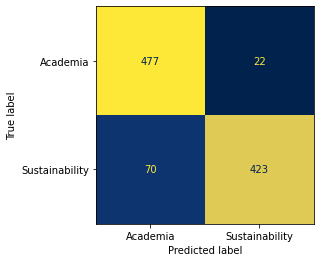

In [10]:
plot_confusion_matrix(gs, X_test, y_test, display_labels=['Academia', 'Sustainability'], cmap='cividis', colorbar=False);

This model has an accuracy score of 90.11%, and struggles in predicting the sustainability subreddit more frequently than it struggles to predict the academia subreddit. With a total of 70 false negatives and 22 false positives where sustainability is the positive class here. This makes for a total of 92 false predictions.

In [11]:
trainscore = gs.score(X_train, y_train)
testscore = gs.score(X_test, y_test)
crossval = cross_val_score(gs, X_train, y_train).mean()
preds = gs.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
recall = metrics.recall_score(y_test, preds)
precision = metrics.precision_score(y_test, preds)
accuracy = testscore
specificity = tn / (tn + fp)

print (f'Train Score = {trainscore}')
print (f'Test Score = {testscore}')
print (f'Cross Val Score = {crossval}')
print (f'Accuracy Score = {testscore}')
print (f'Recall Score = {recall}')
print (f'Precision Score = {precision}')
print (f'Specificity Score = {specificity}')

Train Score = 0.9915966386554622
Test Score = 0.907258064516129
Cross Val Score = 0.9005042016806722
Accuracy Score = 0.907258064516129
Recall Score = 0.8580121703853956
Precision Score = 0.950561797752809
Specificity Score = 0.9559118236472945


I see a lot variance between the train, test, and cross val scores which means theres overfitting happening and needs some bias introduced and reduced features. Next step would be to further tune the Grid Search to include less features and hopefully less misclassifications (shown below with a total of 92 misclassifications).

In [12]:
coefs = pd.DataFrame(pd.Series(gs.best_estimator_.named_steps['log'].coef_[0], index = gs.best_estimator_.named_steps['cvec'].get_feature_names()).sort_values(ascending = False)).head(10)
coefs

,0
sustainability,3.813111
sustainable,3.608215
plastic,2.566082
climate,2.346146
carbon,2.099366
green,1.861947
change,1.601500
world,1.576961
waste,1.550937
environmental,1.521280


The first data frame is showing which features/tokens had the greatest effect on the model. Most of these words would make most humans, myself included, think "Sustainable" before thinking "Academia" which would also lead to why the model does better at predicting the sustainability subreddit.

In [13]:
coefs = pd.DataFrame(pd.Series(gs.best_estimator_.named_steps['log'].coef_[0], index = gs.best_estimator_.named_steps['cvec'].get_feature_names()).sort_values(ascending = False)).tail(10)
coefs

,0
publication,-1.485804
article,-1.564991
science,-1.613598
professor,-1.808880
journal,-1.879099
postdoc,-1.885779
research,-2.010196
academic,-2.312097
phd,-2.635659
academia,-2.727214


# second df. words that turned it off from sust. (positive class). makes complete sense to me

In [14]:
X_test[y_test != preds] 


347     For those of you who switched to a bidet, was ...
1083    Who owns the algorithms? Netflix staff protest...
955     FlyZero: Liquid Hydrogen-Powered Plane Receive...
629     Deets On the January 6th Insurrection Anniversary
1026                  Stressed about Latex Gloves at Work
                              ...                        
1007                                    Chicagoland Peeps
454            Scientific Journal Megathread - by subject
664                   Do everyone a favor: run for office
677     What would you do if you'd 50 million dollars,...
340                   We need to do something about this!
Name: title, Length: 92, dtype: object

#### The dataframe below shows the feature, title in this model, the subreddit the post actually belonged to and where it was predicted to belong to, the probability the logistic regression model calculated to determine which subreddit the post belonged to, and the margin of unsureness represented in the difference of the two probabilities. This data frame is the correct and icncorrect predictions of the test set.

In [15]:
preds_df = pd.DataFrame({
    'title' : X_test, 
    'actual' : y_test, 
    'predicted' : gs.predict(X_test),
    'P(r/Academia)' : [i[0] for i in gs.predict_proba(X_test)],
    'P(r/Sustainability)' : [i[1] for i in gs.predict_proba(X_test)]})
preds_df['Prob Diff'] = np.abs(preds_df['P(r/Sustainability)'] - preds_df['P(r/Academia)'])
preds_df

,title,actual,predicted,P(r/Academia),P(r/Sustainability),Prob Diff
3808,Grad international students in new country,0,0,0.714309,0.285691,0.428618
494,Solarpunk: The Power of an Aesthetic,1,1,0.287701,0.712299,0.424599
3765,Revisiting: Balancing Author Satisfaction with...,0,0,0.860815,0.139185,0.721630
1181,Clean Water... 4Earth,1,1,0.099835,0.900165,0.800331
2287,Paying for co-authorship,0,0,0.747530,0.252470,0.495060
...,...,...,...,...,...,...
2695,Don’t you just enjoy when predatory journals s...,0,0,0.900494,0.099506,0.800989
1971,Example of Retrospective chart review protocol...,0,0,0.817201,0.182799,0.634403
3623,Publishing A Paper? Here are 7 Types Of Peer R...,0,0,0.976604,0.023396,0.953207
2068,How do you find good research partnerships in ...,0,0,0.906982,0.093018,0.813964


#### The dataframe below shows the feature, title_text, the subreddit the post actually belonged to and where it was predicted to belong to, the probability the logistic regression model calculated to determine which subreddit the post belonged to, and the margin of unsureness represented in the difference of the two probabilities. This data frame is only the incorrect predictions of the test set.

In [16]:
pd.set_option('display.max_colwidth', None)
wrong_preds_df = preds_df[preds_df['actual']!=preds_df['predicted']]
very_wrong_preds_df = wrong_preds_df[wrong_preds_df['Prob Diff']>0.5]
very_wrong_preds_df.head()

,title,actual,predicted,P(r/Academia),P(r/Sustainability),Prob Diff
1026,Stressed about Latex Gloves at Work,1,0,0.822107,0.177893,0.644213
344,[Newsletter Update] They tryna cut our lights out like we don't live here - an article about purchasing practices in the apparel industry,1,0,0.766075,0.233925,0.532150
3380,Let's change the culture!,0,1,0.229203,0.770797,0.541594
2899,"Indigenous sidlined on how to handle climate change at COP26 | Academia prefers to preach to the choir, always with their back to the congregation for a sermon that'd rather not start",0,1,0.050985,0.949015,0.898030
197,"I work in natural resources conservation. Our office manager ordered stamps. Before this, they ALWAYS came as loose sheets inside a paper envelope. This time they’re like this. That they’re Earth Day stamps makes it even worse.",1,0,0.776037,0.223963,0.552073


#### The below dataframe sorts the previous dataframe with the first posts being the ones the model felt most sure about, but was wrong.

In [17]:
wrong_preds_df.sort_values(by='Prob Diff', ascending=False).head()

,title,actual,predicted,P(r/Academia),P(r/Sustainability),Prob Diff
2175,10 second video for climate change project,0,1,0.020019,0.979981,0.959962
1622,Computer science college student interested in volunteering,1,0,0.959817,0.040183,0.919634
454,Scientific Journal Megathread - by subject,1,0,0.958059,0.041941,0.916118
2899,"Indigenous sidlined on how to handle climate change at COP26 | Academia prefers to preach to the choir, always with their back to the congregation for a sermon that'd rather not start",0,1,0.050985,0.949015,0.898030
1784,Free online magazine of possible interest...,1,0,0.894148,0.105852,0.788297


## Evaluations:

This model is performing well, but to further answer my question which involves exploring the misclassifications, I believe I can create a model that is more accurate and will provide more concrete paths to understanding why posts are being misclassified, in hopes that it's because the language between the posts are too similar meaning there _is_ conversation about sustainability happening within academia. 